In [2]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3,InceptionResNetV2,Xception,DenseNet121,ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create labels
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [4]:
#resize images and put together Training and Testing folder
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:01<00:00, 70.93it/s]


In [5]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [6]:

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [7]:

ResNet152=ResNet152(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


234708992/234698864 [==============================] - 4s 0us/step


In [8]:
#train the model
tf.random.set_seed(79)
model = ResNet152.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=ResNet152.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [9]:
# summarize the model
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']         

In [10]:

# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 122s 217ms/step - loss: 0.6663 - accuracy: 0.7491 - val_loss: 0.6982 - val_accuracy: 0.8496
Epoch 2/70
348/348 [==============================] - 72s 208ms/step - loss: 0.2296 - accuracy: 0.9216 - val_loss: 0.3129 - val_accuracy: 0.9106
Epoch 3/70
348/348 [==============================] - 74s 213ms/step - loss: 0.1106 - accuracy: 0.9626 - val_loss: 1.7547 - val_accuracy: 0.8191
Epoch 4/70
348/348 [==============================] - 72s 207ms/step - loss: 0.0604 - accuracy: 0.9824 - val_loss: 0.5057 - val_accuracy: 0.8943
Epoch 5/70
348/348 [==============================] - 72s 208ms/step - loss: 0.0469 - accuracy: 0.9874 - val_loss: 0.3387 - val_accuracy: 0.9329


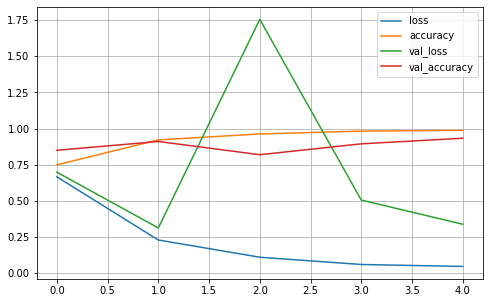

In [11]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [12]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 3s 161ms/step - loss: 0.3129 - accuracy: 0.9106


In [13]:
#print accuracy    
print('Accuracy: %f' % (accuracy*100))

Accuracy: 91.056913


In [14]:
#acuracy and loss
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 91.057 
 loss : 0.313


In [15]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
#pred_labels

In [16]:
pd.Series(pred_labels).value_counts()

pituitary_tumor     137
glioma_tumor        136
meningioma_tumor    119
no_tumor            100
dtype: int64

Text(70.8, 0.5, 'Predicted class')

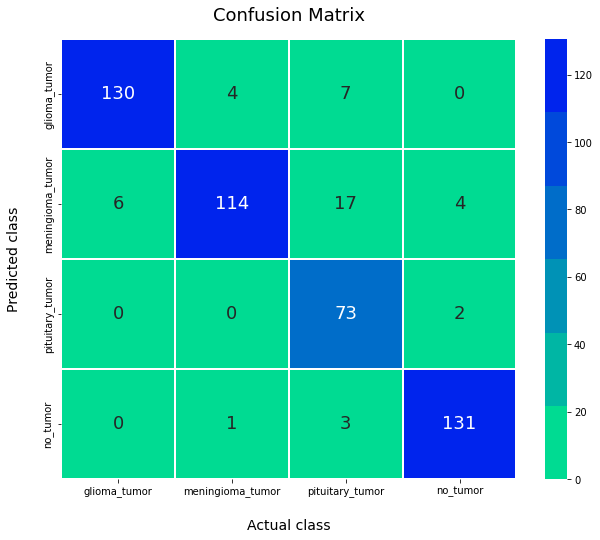

In [17]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

In [18]:
#y_test_labels
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.92      0.94       141
meningioma_tumor       0.96      0.81      0.88       141
 pituitary_tumor       0.73      0.97      0.83        75
        no_tumor       0.96      0.97      0.96       135

        accuracy                           0.91       492
       macro avg       0.90      0.92      0.90       492
    weighted avg       0.92      0.91      0.91       492

